# CWT & STFT + CNN Model with Unicorn Hybrid Black dataset

In [401]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage

raw_each = [0] * 8

for i in range(0,8):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws(raw_each)
# raw_edf = mne.concatenate_raws([raw_each[1], raw_each[3], raw_each[4]])
# raw_edf = mne.concatenate_raws([raw_each[0], raw_each[5], raw_each[6]])

raw_edf = mne.concatenate_raws([raw_each[3]])

# raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\MI_execution.edf", preload=True)

eegbci.standardize(raw_edf)  # set channel names
montage = make_standard_montage("standard_1005")
raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...


Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand5_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand6_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand7_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189249  =      0.000 ...   756.996 secs...


<RawEDF | hand4_new.edf, 8 x 279250 (1117.0 s), ~17.1 MB, data loaded>

In [402]:
# raw_edf.plot(scalings = 100, start= 45,  duration=5)

In [403]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation, Dropout
from keras.models import Sequential
from keras.callbacks import History,ModelCheckpoint
from keras.utils import plot_model
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from ssqueezepy import ssq_cwt, ssq_stft
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [404]:
eeg1 = raw_edf.copy().filter(l_freq=6.0, h_freq=32.0, method = 'iir', iir_params= {"order": 5, "ftype":'butter'})
# eeg1 = raw_edf.copy().filter(l_freq=0.075, h_freq=3.0, method = 'fir')
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

eeg1= eeg1.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])
# eeg1= eeg1.pick_channels(["C3", "Cz", "C4"])
events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin= 0.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 4.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(0, 0)
    )

combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=1.0)
component_num = 7

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 6.00, 32.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
612 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 612 events and 1001 original time points ...
1 bad epochs dropped


In [405]:
combine_epochs

Number of events,611
Events,OVTK_GDF_Cross_On_Screen: 7OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Incorrect: 1OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 1OVTK_StimulationId_Train: 0
Time range,0.000 – 1.000 s
Baseline,0.000 – 0.000 s


In [406]:
df_left = combine_epochs['OVTK_GDF_Left'].to_data_frame()
df_right = combine_epochs['OVTK_GDF_Right'].to_data_frame()
df_up = combine_epochs['OVTK_GDF_Up'].to_data_frame()
df_tongue = combine_epochs['OVTK_GDF_Tongue'].to_data_frame()
df_left =df_left.iloc[:, -7:]
df_right =df_right.iloc[:, -7:]
df_up =df_up.iloc[:, -7:]
df_tongue =df_tongue.iloc[:, -7:]

# # Plot histograms for all columns in the DataFrame using Seaborn
# fig, ax = plt.subplots(1, len(df_left.columns),sharey=True, figsize=(10 * len(df_left.columns), 10))
# for i, column in enumerate(df_left.columns):
#     ax[i] = sns.histplot(df_left[column], kde=False, ax=ax[i], color= 'orange')
#     ax[i] = sns.histplot(df_right[column], kde=False, ax=ax[i], color= 'blue')
#     ax[i] = sns.histplot(df_up[column], kde=False, ax=ax[i], color= 'green')
#     ax[i] = sns.histplot(df_tongue[column], kde=False, ax=ax[i], color= 'pink')
#     ax[i].set_xlabel(column,  fontsize=30)
#     ax[i].set_ylabel('Frequency',  fontsize=30)
#     ax[i].tick_params(axis='both', labelsize=30)

# plt.tight_layout()
# plt.show()

In [407]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Example DataFrame (replace this with your actual DataFrame)
# data = {
#     'column1': [1, 2, 3, 4, 5],
#     'column2': [2, 3, 4, 5, 6],
#     'column3': [3, 4, 5, 6, 7],
#     'column4': [4, 5, 6, 7, 8],
#     'column5': [5, 6, 7, 8, 9]
# }
# df = pd.DataFrame(data)

# # Select the last three columns
# last_three_columns = df.iloc[:, -3:]

# # Plot histograms for the last three columns using Seaborn in a horizontal line
# fig, ax = plt.subplots(1, len(last_three_columns.columns), sharey=True, figsize=(6 * len(last_three_columns.columns), 6))
# for i, column in enumerate(last_three_columns.columns):
#     sns.histplot(last_three_columns[column], kde=False, bins=10, ax=ax[i])
#     ax[i].set_xlabel(column)
#     ax[i].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

TRY FBCSP

In [408]:
# labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]
# for i in range(0,len(labels)):
#     if labels[i] > 7:
#         labels[i] = labels[i] - 1
#     # if labels[i] < 7:
#     #     labels[i] = labels[i] + 1

# low_fre = [6, 10, 14, 18, 22, 26]
# high_fre = [12, 16, 20, 24, 28, 32]

# shape = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data().shape

# train_data = np.ndarray(shape= (6,shape[0],shape[1],shape[2]))

# new_data = np.ndarray(shape= (6,shape[0],shape[1],shape[2]))
# # new_data = np.ndarray(shape= (6,shape[0],shape[1]))


# for i in range(0,6):
#     combine_epochs = combine_epochs.filter(l_freq=low_fre[i], h_freq=high_fre[i], method = 'iir', iir_params= {"order": 5, "ftype":'butter'}, verbose = False)
#     train_data[i] = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
    
#     # csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
#     # # csp = CSP(n_components=component_num, reg=None, log=None)
#     # csp.fit(train_data[i], labels)

#     # with open('trained_FBCSP_model'+str(i)+'.pkl', 'wb') as file:
#     #     pickle.dump(csp, file)

# for j in range(0,6):
#     with open('trained_FBCSP_model'+str(j)+'.pkl', 'rb') as file:
#         trained_csp = pickle.load(file)

#     new_data[j] = trained_csp.transform(train_data[j])

# new_data = np.concatenate(new_data, axis = 1)

In [409]:
# # lda3 = LinearDiscriminantAnalysis()
# # lda3.fit(new_data, labels)
# # with open('trained_lda3_model.pkl', 'wb') as file:
# #     pickle.dump(lda3, file)

# with open('trained_lda3_model.pkl', 'rb') as file:
#     trained_lda3 = pickle.load(file)


# # score = cross_val_score(trained_lda3, new_data, labels, cv= 10)
# # lda_predicted = cross_val_predict(trained_lda3, new_data, labels, cv= 10)
# # conf_matrix = confusion_matrix(labels, lda_predicted)
# # print("LDA only classification scores", np.mean(score))
# # print(conf_matrix)

# score = trained_lda3.score(new_data, labels)
# lda_predicted = trained_lda3.predict(new_data)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", score)
# print(conf_matrix)

In [410]:
combine_epochs.event_id

{'OVTK_GDF_Cross_On_Screen': 1,
 'OVTK_GDF_End_Of_Session': 2,
 'OVTK_GDF_End_Of_Trial': 3,
 'OVTK_GDF_Feedback_Continuous': 4,
 'OVTK_GDF_Incorrect': 5,
 'OVTK_GDF_Left': 6,
 'OVTK_GDF_Right': 7,
 'OVTK_GDF_Start_Of_Trial': 8,
 'OVTK_GDF_Tongue': 9,
 'OVTK_GDF_Up': 10,
 'OVTK_StimulationId_BaselineStart': 11,
 'OVTK_StimulationId_Beep': 13,
 'OVTK_StimulationId_ExperimentStart': 14,
 'OVTK_StimulationId_Train': 15}

# CSP -> CWT -> CNN

In [411]:
# Prepare Labels and Train data
labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]
for i in range(0,len(labels)):
    if labels[i] > 7:
        labels[i] = labels[i] - 1
    # if labels[i] < 7:
    #     labels[i] = labels[i] + 1
train_data = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()

# ################ 3 Classes #######################
# labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up'].events[:,2]
# for i in range(0,len(labels)):
#     if labels[i] > 7:
#         labels[i] = labels[i] - 1
#     if labels[i] <= 7:
#         labels[i] = labels[i] + 1
# train_data = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up'].get_data()

In [412]:
labels

array([9, 8, 7, 9, 9, 8, 8, 9, 8, 7, 9, 8, 7, 8, 9, 7, 7, 7, 9, 7, 9, 8,
       7, 9, 7, 9, 8, 8, 9, 7, 9, 9, 9, 8, 7, 9, 8, 7, 9, 8, 7, 9, 8, 7,
       9, 7, 9, 7, 8, 9, 9, 8, 7, 8, 8, 7, 9, 9, 8, 7, 9, 8, 7, 9, 8, 7,
       7, 8, 7, 9, 8, 9, 8, 7, 9, 8, 7, 9, 7, 8, 7, 8, 8, 7, 9, 8, 7, 8,
       8, 7])

train csp

In [413]:
# csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
# csp.fit(train_data, labels)

# with open('trained_csp3class_model.pkl', 'wb') as file:
#     pickle.dump(csp, file)

load csp

In [414]:
with open('trained_csp3class_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)
print(new_data.shape)

(90, 7, 251)


try csp+lda trined model

In [415]:
# csp2 = CSP(n_components=7, reg=None, log=None)
# csp2.fit(train_data, labels)
# with open('trained_csp2_model.pkl', 'wb') as file:
#     pickle.dump(csp2, file)

with open('trained_csp2_model.pkl', 'rb') as file:
    trained_csp2 = pickle.load(file)
new_data2 = trained_csp2.transform(train_data)

# lda2 = LinearDiscriminantAnalysis()
# lda2.fit(new_data2, labels)
# with open('trained_lda_model.pkl', 'wb') as file:
#     pickle.dump(lda2, file)

with open('trained_lda_model.pkl', 'rb') as file:
    trained_lda = pickle.load(file)

    
# score = cross_val_score(trained_lda,new_data2, labels, cv= 10)
# lda_predicted = cross_val_predict(trained_lda, new_data2, labels, cv=10)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", np.mean(score))
# print(conf_matrix)

score = trained_lda.score(new_data2, labels)
lda_predicted = trained_lda.predict(new_data2)
conf_matrix = confusion_matrix(labels, lda_predicted)
print("LDA only classification scores", score)
print(conf_matrix)


LDA only classification scores 0.2777777777777778
[[ 0  0  0  0]
 [ 4 17  2  7]
 [ 3 23  1  3]
 [ 7 14  2  7]]


In [416]:
np.shape(new_data)

(90, 7, 251)

Plot topographic patterns of components. The patterns explain how the measured data was generated from the neural sources (a.k.a. the forward model)

In [417]:
# trained_csp.plot_patterns(combine_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5, vlim=(-5e6, 5e6))
# print('...')

In [418]:
# selected_events = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue']
# csp_epochs = mne.EpochsArray(new_data, selected_events.info, events=selected_events.events, event_id= selected_events.event_id)
# channel_mapping = {
#     'Fz': 'csp1',
#     'C3': 'csp2',
#     'Cz': 'csp3',
#     'C4': 'csp4',
#     'Pz': 'csp5',
#     'PO7': 'csp6',
#     'PO8': 'csp7'
# }
# csp_epochs.rename_channels(channel_mapping)

# csp_left_df = csp_epochs['OVTK_GDF_Left'].to_data_frame()
# csp_right_df = csp_epochs['OVTK_GDF_Right'].to_data_frame()
# csp_up_df = csp_epochs['OVTK_GDF_Up'].to_data_frame()
# csp_tongue_df = csp_epochs['OVTK_GDF_Tongue'].to_data_frame()

# csp_left_df =csp_left_df.iloc[:, -7:]
# csp_right_df =csp_right_df.iloc[:, -7:]
# csp_up_df =csp_up_df.iloc[:, -7:]
# csp_tongue_df =csp_tongue_df.iloc[:, -7:]

# # Plot histograms for all columns in the DataFrame using Seaborn
# fig, ax = plt.subplots(1, len(csp_left_df.columns),sharey=True, figsize=(10 * len(csp_left_df.columns), 10))
# for i, column in enumerate(csp_left_df.columns):
#     ax[i] = sns.histplot(csp_left_df[column], kde=False, ax=ax[i], color= 'orange')
#     ax[i] = sns.histplot(csp_right_df[column], kde=False, ax=ax[i], color= 'blue')
#     ax[i] = sns.histplot(csp_up_df[column], kde=False, ax=ax[i], color= 'green')
#     ax[i] = sns.histplot(csp_tongue_df[column], kde=False, ax=ax[i], color= 'pink')
#     ax[i].set_xlabel(column,  fontsize=30)
#     # ax[i].set_xlim(-1e7, 1e7)
#     ax[i].set_ylabel('Frequency',  fontsize=30)
#     ax[i].tick_params(axis='both', labelsize=30)
# plt.tight_layout()
# plt.show()

STFT

In [419]:
# from ssqueezepy import ssq_cwt, ssq_stft

# n_fft = 256  # Number of DFT points
# hop_length = int(n_fft * 0.03)  # 97% overlapping
# win_length = int(n_fft * 0.5)   # 0.5 seconds window length
# window = 'hamming' 
# train_size = len(labels)
# train_data_stft = np.ndarray(shape=(train_size,component_num, 129, 72))


# # _,coeff, *_ = ssq_stft(new_data[0,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
# for i in range(0,train_size):
#     _,coeff, *_ = ssq_stft(new_data[i,:], n_fft=n_fft, hop_len=hop_length, win_len=win_length, window=window)
#     train_data_stft[i, :, :, :] = abs(coeff)

# print(np.shape(train_data_stft))

# # Stack array and convert to image
# train_stft_stack = np.ndarray(shape=(train_size, train_data_stft.shape[2],train_data_stft.shape[3]*component_num))

# for jj in range(0,train_data_stft.shape[0]):
#     train_stft_stack[jj] = np.concatenate(train_data_stft[jj], axis = 1)
#     # train_stft_stack[jj] = np.vstack((train_data_stft[jj,0,:,:], train_data_stft[jj,1,:,:], train_data_stft[jj,2,:,:], train_data_stft[jj,3,:,:], train_data_stft[jj,4,:,:], train_data_stft[jj,5,:,:], train_data_stft[jj,6,:,:]))

# print(np.shape(train_stft_stack))

CWT

In [420]:
FB = 1
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], component_num*FB))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(train_cwt))

scales = range(1,31)

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], component_num*FB))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,component_num*FB):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]]  #crop 227 sample for each channel
        train_data_cwt[ii, :, :, jj] = coeff_
print(np.shape(train_data_cwt))

train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*component_num*FB, new_data.shape[2]))

# train_cwt_stack = np.ndarray(shape=(train_size , new_data.shape[2], len(scales)*component_num*FB))


for jj in range(0,train_data_cwt.shape[0]):
    # train_cwt_stack[jj] = np.concatenate(train_data_cwt[jj], axis = 1)
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6]))

print(np.shape(train_cwt_stack))

(90, 251, 7)
0
40
80
(90, 30, 251, 7)
(90, 210, 251)


Try scaler

In [421]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# reshaped_data = train_cwt_stack.reshape((train_cwt_stack.shape[0], -1))
# scaled_data = scaler.fit_transform(reshaped_data)
# scaled_data_3d = scaled_data.reshape(train_cwt_stack.shape)
# print(scaled_data_3d.shape)

In [422]:
# train_cwt_stack = new_data

x_train, x_test, y_train, y_test = train_test_split(train_cwt_stack, labels, test_size=0.3, random_state=42)

num_classes = 4

batch_size = 1
epochs = 30
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

y_train = keras.utils.to_categorical(y_train-7, num_classes)
y_test = keras.utils.to_categorical(y_test-7, num_classes)

(63, 210, 251) (27, 210, 251) (63,) (27,)


# Purposed CNN Model

In [423]:
# # Define the CNN model
# model = Sequential()

# # Convolutional Layer 1 with 32 filters of kernel size 3x3
# model.add(Conv2D(32, (3, 3), input_shape=(train_cwt_stack.shape[1], train_cwt_stack.shape[2], 1), activation='relu'))
# # model.add(BatchNormalization())
# # Max-Pooling Layer 1 with pool size 2x2
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Convolutional Layer 2 with 64 filters of kernel size 3x3
# model.add(Conv2D(64, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5)) 

# # Max-Pooling Layer 2 with pool size 2x2
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten the output from the previous layer
# model.add(Flatten())

# # Output Layer with the desired number of output nodes (adjust as needed)
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy, 
#               optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
#               metrics=['accuracy'])

# model.summary()
# plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# checkpoint = ModelCheckpoint("CNN_model1s_3c_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# model.fit(x_train, y_train, batch_size=batch_size, 
#           epochs=epochs, verbose=1, 
#           validation_data=(x_test, y_test), 
#           callbacks=[history, checkpoint])

3/3 [==============================] - 1s 140ms/step


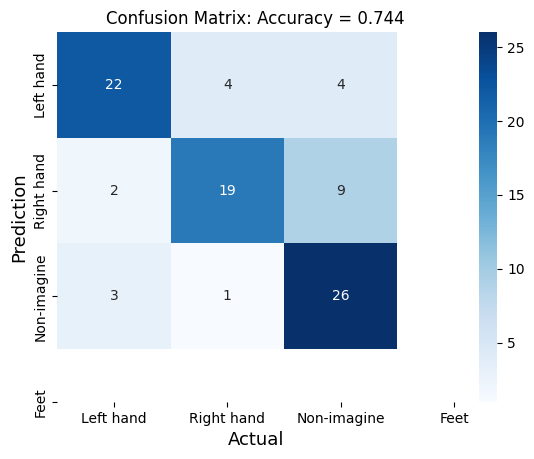

In [424]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN_model1s_3c_weights.h5")

y_test = keras.utils.to_categorical(labels -7 , num_classes)

loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

y_pred = pretrained_model.predict(train_cwt_stack)
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)

class_names = ['Left hand', 'Right hand',  'Non-imagine', 'Feet']
# class_names = ['imagine',  'Non-imagine',]

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()

In [425]:
# y_pred